In [29]:
#FUNCTION TO IMPORT ACCELEROMETER DATA
import csv
import os
import numpy as np
import scipy.stats as stats
import random
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import scipy.signal as sig



print(os.getcwd())
my_directory = '/Users/apara/Documents/GitHub/hsl_python/SpaceVestibExperiment' 
folder = 'Ma1' #change this based on person

def import_accel(rootdir, foldername):

    directory = rootdir + '/' + foldername + '/Acc' 

    os.chdir(directory)

    for r, d, files in os.walk(directory):
        for filename in files:
            if 'si' in filename and 'up' in filename:
                si_up = np.loadtxt(filename, delimiter = ',', skiprows=1, usecols = (1,2,3,4,5,6))
            elif 'si' in filename and 'p' in filename:
                si_p = np.loadtxt(filename, delimiter = ',', skiprows=1, usecols = (1,2,3,4,5,6))
            elif 'st' in filename and 'up' in filename: 
                st_up = np.loadtxt(filename, delimiter = ',', skiprows=1, usecols = (1,2,3,4,5,6))
            elif 'st' in filename and 'p' in filename: 
                st_p = np.loadtxt(filename, delimiter = ',', skiprows=1, usecols = (1,2,3,4,5,6))    
    return si_up.transpose(), si_p.transpose(), st_up.transpose(), st_p.transpose()

ak_accel = import_accel(my_directory, folder) #ak_accel[0] = 6x400 matrix (only up1,sit)


/Users/apara/Documents/GitHub/hsl_python/SpaceVestibExperiment/Ma1/Acc


In [10]:
#These are all Vedant's stats functions from the shimmer file
def scaled_correlation_time(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    tau = np.argmax([acorr < 1/np.exp(1)])
    return tau / len(acorr)

def signal_statistics(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    skewness = stats.skew(signal)
    kurtosis = stats.kurtosis(signal)
    maximum = np.max(signal)
    minimum = np.min(signal)
    iqr = stats.iqr(signal)
    variation = stats.variation(signal)
    entropy = stats.entropy(np.abs(signal))
    corrtime = scaled_correlation_time(signal,signal)        
    return np.asarray([mean, std, skewness, kurtosis, maximum, minimum, variation, entropy])

def spectrum_statistics(signal):
    fs,pxx = sig.periodogram(signal, fs = 50, nfft = 1000, scaling = 'density', detrend = 'constant')
#   plt.plot(fs,pxx)
    #plt.xlim(0,0.1)
    peak = fs[np.argmax(pxx)]
    peakmag = np.max(pxx)
    integral = np.trapz(pxx,fs)
    energy = np.dot(pxx,pxx)
    shannon = np.sum(pxx*np.log(1/pxx))
    return [peak, peakmag, integral, energy, shannon]


In [11]:
#outputs a 4*6*8 array -- all the signal stats (all 4 phases, all 6 directions) per person

def create_array(person):
    signal_list = []
    for run in range(4):
        for measure in range(6):
            new_list_measure = [signal_statistics(ak_accel[run][measure])]
            signal_list.append(new_list_measure)

    signal_arr = np.asarray(signal_list)
    signal_arr = signal_arr.reshape(4,6,8)

    return signal_arr


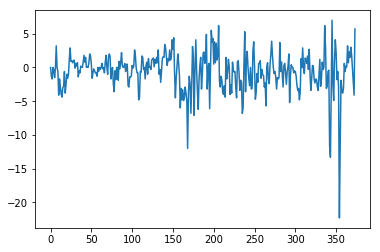

In [12]:
i = 3 #input number from 0-3; representing UP-SI, P-SI, UP-ST, P-ST
j = 3 #input number from 0-5; representing x,y,z linear and x,y,z rotational

plt.plot(ak_accel[i][j])
plt.show()


In [30]:
#butterworth filter!!
n, Wn = sig.buttord(8/500, 32/500, 3, 60)
b,a = sig.butter(n,Wn)
new_sig = sig.lfilter(b,a,signal)


NameError: name 'signal' is not defined

In [21]:
def accel_stats(subj_arr):
    min_length = min(len(subj_arr[0][0]),len(subj_arr[1][0]),len(subj_arr[2][0]),len(subj_arr[3][0]),len(subj_arr[0][2]),len(subj_arr[1][2]),len(subj_arr[2][2]),len(subj_arr[3][2]))
    
    # t-test:
    # unperturbed versus perturbed:
    upvp_si_AP = stats.ttest_ind(subj_arr[0][0][0:min_length],subj_arr[1][0][0:min_length])
    upvp_st_AP = stats.ttest_ind(subj_arr[2][0][0:min_length],subj_arr[3][0][0:min_length])
    upvp_si_ML = stats.ttest_ind(subj_arr[0][2][0:min_length],subj_arr[1][2][0:min_length])
    upvp_st_ML = stats.ttest_ind(subj_arr[2][2][0:min_length],subj_arr[3][2][0:min_length])
    
    #standing versus sitting
    sivst_up_AP = stats.ttest_ind(subj_arr[0][0][0:min_length],subj_arr[2][0][0:min_length])
    sivst_p_AP = stats.ttest_ind(subj_arr[1][0][0:min_length],subj_arr[3][0][0:min_length]) 
    sivst_up_ML = stats.ttest_ind(subj_arr[0][2][0:min_length],subj_arr[2][2][0:min_length])
    sivst_p_ML = stats.ttest_ind(subj_arr[1][2][0:min_length],subj_arr[3][2][0:min_length])
    
    #extremes comparison
    siup_v_stp_AP = stats.ttest_ind(subj_arr[0][0][0:min_length],subj_arr[3][0][0:min_length])
    siup_v_stp_ML = stats.ttest_ind(subj_arr[0][2][0:min_length],subj_arr[3][2][0:min_length])
    
    #ttestarrVAN = np.array([upvp_si_VAN,upvp_st_VAN,sivst_up_VAN,sivst_p_VAN,siup_v_stp_VAN])
    #ttestarrTAN = np.array([upvp_si_TAN,upvp_st_TAN,sivst_up_TAN,sivst_p_TAN,siup_v_stp_TAN])
    #ttestarr = np.array([ttestarrVAN,ttestarrTAN])
    ttestarr = np.array([upvp_si_AP,upvp_si_ML,upvp_st_AP,upvp_st_ML,sivst_up_AP,sivst_up_ML,sivst_p_AP,sivst_p_ML,siup_v_stp_AP,siup_v_stp_ML])
    
    # Mann-Whitney U test:
    # unperturbed versus perturbed:
    upvp_si_AP = stats.mannwhitneyu(subj_arr[0][0][0:min_length],subj_arr[1][0][0:min_length])
    upvp_st_AP = stats.mannwhitneyu(subj_arr[2][0][0:min_length],subj_arr[3][0][0:min_length])
    upvp_si_ML = stats.mannwhitneyu(subj_arr[0][2][0:min_length],subj_arr[1][2][0:min_length])
    upvp_st_ML = stats.mannwhitneyu(subj_arr[2][2][0:min_length],subj_arr[3][2][0:min_length])
    
    #standing versus sitting
    sivst_up_AP = stats.mannwhitneyu(subj_arr[0][0][0:min_length],subj_arr[2][0][0:min_length])
    sivst_p_AP = stats.mannwhitneyu(subj_arr[1][0][0:min_length],subj_arr[3][0][0:min_length]) 
    sivst_up_ML = stats.mannwhitneyu(subj_arr[0][2][0:min_length],subj_arr[2][2][0:min_length])
    sivst_p_ML = stats.mannwhitneyu(subj_arr[1][2][0:min_length],subj_arr[3][2][0:min_length])

    
    #extremes comparison
    siup_v_stp_AP = stats.mannwhitneyu(subj_arr[0][0][0:min_length],subj_arr[3][0][0:min_length])
    siup_v_stp_ML = stats.mannwhitneyu(subj_arr[0][2][0:min_length],subj_arr[3][2][0:min_length])

    
    #mannwhitneyarrVAN = np.array([upvp_si_VANmw,upvp_st_VANmw,sivst_up_VANmw,sivst_p_VANmw,siup_v_stp_VANmw])
    #mannwhitneyarrTAN = np.array([upvp_si_TANmw,upvp_st_TANmw,sivst_up_TANmw,sivst_p_TANmw,siup_v_stp_TANmw])
    #mannwhitneyarr = np.array([mannwhitneyarrVAN,mannwhitneyarrTAN])
    mannwhitneyarr = np.array([upvp_si_AP,upvp_si_ML,upvp_st_AP,upvp_st_ML,sivst_up_AP,sivst_up_ML,sivst_p_AP,sivst_p_ML,siup_v_stp_AP,siup_v_stp_ML])
    
    # Kruskal Wallis test:
    # unperturbed versus perturbed:
    upvp_si_AP = stats.kruskal(subj_arr[0][0][0:min_length],subj_arr[1][0][0:min_length])
    upvp_st_AP = stats.kruskal(subj_arr[2][0][0:min_length],subj_arr[3][0][0:min_length])
    upvp_si_ML = stats.kruskal(subj_arr[0][2][0:min_length],subj_arr[1][2][0:min_length])
    upvp_st_ML = stats.kruskal(subj_arr[2][2][0:min_length],subj_arr[3][2][0:min_length])

    
    #standing versus sitting
    sivst_up_AP = stats.kruskal(subj_arr[0][0][0:min_length],subj_arr[2][0][0:min_length])
    sivst_p_AP = stats.kruskal(subj_arr[1][0][0:min_length],subj_arr[3][0][0:min_length]) 
    sivst_up_ML = stats.kruskal(subj_arr[0][2][0:min_length],subj_arr[2][2][0:min_length])
    sivst_p_ML = stats.kruskal(subj_arr[1][2][0:min_length],subj_arr[3][2][0:min_length])
    
    #extremes comparison
    siup_v_stp_AP = stats.kruskal(subj_arr[0][0][0:min_length],subj_arr[3][0][0:min_length])
    siup_v_stp_ML = stats.kruskal(subj_arr[0][2][0:min_length],subj_arr[3][2][0:min_length])

    
    #kruskalwallisarrVAN = np.array([upvp_si_VANk,upvp_st_VANk,sivst_up_VANk,sivst_p_VANk,siup_v_stp_VANk])
    #kruskalwallisarrTAN = np.array([upvp_si_TANk,upvp_st_TANk,sivst_up_TANk,sivst_p_TANk,siup_v_stp_TANk])
    #kruskalwallisarr = np.array([kruskalwallisarrVAN,kruskalwallisarrTAN])
    kruskalwallisarr = np.array([upvp_si_AP,upvp_si_ML,upvp_st_AP,upvp_st_ML,sivst_up_AP,sivst_up_ML,sivst_p_AP,sivst_p_ML,siup_v_stp_AP,siup_v_stp_ML])
   

    #Wilcoxon signed-rank test 
    # unperturbed versus perturbed:
    upvp_si_AP = stats.wilcoxon(subj_arr[0][0][0:min_length],subj_arr[1][0][0:min_length])
    upvp_st_AP = stats.wilcoxon(subj_arr[2][0][0:min_length],subj_arr[3][0][0:min_length])
    upvp_si_ML = stats.wilcoxon(subj_arr[0][2][0:min_length],subj_arr[1][2][0:min_length])
    upvp_st_ML = stats.wilcoxon(subj_arr[2][2][0:min_length],subj_arr[3][2][0:min_length])

    
    #standing versus sitting
    sivst_up_AP = stats.wilcoxon(subj_arr[0][0][0:min_length],subj_arr[2][0][0:min_length])
    sivst_p_AP = stats.wilcoxon(subj_arr[1][0][0:min_length],subj_arr[3][0][0:min_length]) 
    sivst_up_ML = stats.wilcoxon(subj_arr[0][2][0:min_length],subj_arr[2][2][0:min_length])
    sivst_p_ML = stats.wilcoxon(subj_arr[1][2][0:min_length],subj_arr[3][2][0:min_length])
    
    #extremes comparison
    siup_v_stp_AP = stats.wilcoxon(subj_arr[0][0][0:min_length],subj_arr[3][0][0:min_length])
    siup_v_stp_ML = stats.wilcoxon(subj_arr[0][2][0:min_length],subj_arr[3][2][0:min_length])

    
    #wilcoxonarrVAN = np.array([upvp_si_VANw,upvp_st_VANw,sivst_up_VANw,sivst_p_VANw,siup_v_stp_VANw])
    #wilcoxonarrTAN = np.array([upvp_si_TANw,upvp_st_TANw,sivst_up_TANw,sivst_p_TANw,siup_v_stp_TANw])
    #wilcoxonarr = np.array([wilcoxonarrVAN,wilcoxonarrTAN])
    wilcoxonarr = np.array([upvp_si_AP,upvp_si_ML,upvp_st_AP,upvp_st_ML,sivst_up_AP,sivst_up_ML,sivst_p_AP,sivst_p_ML,siup_v_stp_AP,siup_v_stp_ML])
    
    return ttestarr, mannwhitneyarr, kruskalwallisarr, wilcoxonarr

s1_statisticsarr = accel_stats(ak_accel)

In [27]:
for i in range(len(s1_statisticsarr)):
    for j in range(len(s1_statisticsarr[i])):
        for k in range(2):
            s1_statisticsarr[i][j][k] = "%.2e"%(s1_statisticsarr[i][j][k])
fig = go.Figure(data=[go.Table(
    columnorder = [1,2,3,4,5],
    columnwidth = [400,500],
    header=dict(values=['Comparison', 'T-test', 'Mann-Whitney U', 'Kruskal Wallis', 'Wilcoxon'],
                align='left'),
    cells=dict(values=[['UP vs. P: SI (VAN)', 'UP vs. P: SI (TAN)','UP vs. P: ST (VAN)', 'UP vs. P: ST (TAN)', 'SI vs. ST: UP (VAN)','SI vs. ST: UP (TAN)', 'SI vs. ST: P (VAN)','SI vs. ST: P (TAN)', 'UP SI vs. P ST (VAN)', 'UP SI vs. P ST (TAN)'], # 1st column
                        [s1_statisticsarr[0][0][1], s1_statisticsarr[0][1][1], s1_statisticsarr[0][2][1], s1_statisticsarr[0][3][1], s1_statisticsarr[0][4][1], s1_statisticsarr[0][5][1], s1_statisticsarr[0][6][1], s1_statisticsarr[0][7][1], s1_statisticsarr[0][8][1], s1_statisticsarr[0][9][1]],
                        [s1_statisticsarr[1][0][1], s1_statisticsarr[1][1][1], s1_statisticsarr[1][2][1], s1_statisticsarr[1][3][1], s1_statisticsarr[1][4][1], s1_statisticsarr[1][5][1], s1_statisticsarr[1][6][1], s1_statisticsarr[1][7][1], s1_statisticsarr[1][8][1], s1_statisticsarr[1][9][1]],
                        [s1_statisticsarr[2][0][1], s1_statisticsarr[2][1][1], s1_statisticsarr[2][2][1], s1_statisticsarr[2][3][1], s1_statisticsarr[2][4][1], s1_statisticsarr[2][5][1], s1_statisticsarr[2][6][1], s1_statisticsarr[2][7][1], s1_statisticsarr[2][8][1], s1_statisticsarr[2][9][1]],
                        [s1_statisticsarr[3][0][1], s1_statisticsarr[3][1][1], s1_statisticsarr[3][2][1], s1_statisticsarr[3][3][1], s1_statisticsarr[3][4][1], s1_statisticsarr[3][5][1], s1_statisticsarr[3][6][1], s1_statisticsarr[3][7][1], s1_statisticsarr[3][8][1], s1_statisticsarr[3][9][1]]], 
                align='left'))])

fig.layout.width=1000
headerColor = 'grey'
rowEvenColor = 'lightgrey'
rowOddColor = 'white'

fig.show()
